In [37]:
%load_ext autoreload
%autoreload 2

In [51]:
# %load "/Users/haleighwright/Desktop/NCEAS/pyriv/notebooks/nb_config.py"
import sys
sys.path.append("/Users/haleighwright/Desktop/NCEAS/pyriv")
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")
import networkx as nx
import numpy as np
import sys
import geopandas as gpd
import seaborn # makes matplotlib graphs look prettier
from shapely.geometry import Point
from multiprocessing import Pool

from pyriv import graph_prep as GraphBuilder
from pyriv import river_graph as RiverGraph
from pyriv import snapping_processor as SnapTool

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # makes matplotlib graphs 2x resolution for retina display

In [2]:
from pyriv import point_processor as PointProcessor

In [3]:
import pylab as plt

In [31]:
import collections

In [3]:
%pwd

u'/Users/haleighwright/Desktop/NCEAS/pyriv/notebooks/dev/Experimental'

In [5]:
#ak = GraphBuilder.read_from_file('../../../../Data/sasap/NatMapCoastline3338/NatMapGDF/NatMapGDF.shp')

In [4]:
%%time
ak = GraphBuilder.read_from_file('ak.gpickle')

Weighting Edges with Distances
CPU times: user 1min 11s, sys: 8.08 s, total: 1min 19s
Wall time: 1min 20s


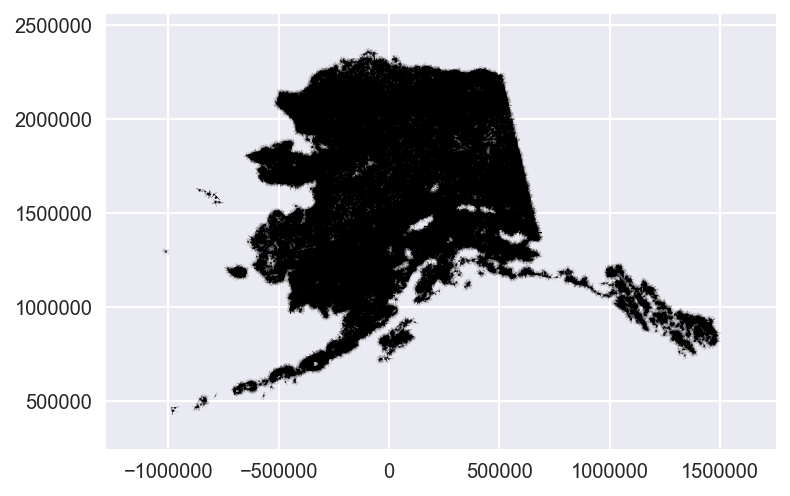

In [4]:
ak.plot()

In [21]:
in_degrees = ak.in_degree() # dictionary node:degree
in_values = sorted(set(in_degrees.values()))
in_hist = [in_degrees.values().count(x) for x in in_values]

In [22]:
out_degrees = ak.out_degree() # dictionary node:degree
out_values = sorted(set(out_degrees.values()))
out_hist = [out_degrees.values().count(x) for x in out_values]

In [23]:
plt.figure()
plt.plot(in_values,in_hist,'ro-') # in-degree
plt.plot(out_values,out_hist,'bv-') # out-degree
plt.legend(['In-degree','Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Alaskan River Network')
plt.savefig('ak_degree_distribution.pdf')
plt.close()

In [30]:
print out_values
print out_hist

[0, 1, 2]
[2262, 415776, 82]


In [32]:
print in_values
print in_hist

[0, 1, 2, 3]
[16465, 387374, 14277, 4]


In [16]:
print ak.copy

<bound method RiverGraph.copy of <pyriv.river_graph.RiverGraph object at 0x10a8aefd0>>


In [11]:
graph_copy = ak.copy()
print len(graph_copy.edges())

415940


In [14]:
print len(ak.nodes())

418120


In [12]:
%%time
allnodes_missingedges = SnapTool.missing_edges_list(ak, 0.75, 'ak_highres_snapped.shp')

<class 'pyriv.river_graph.RiverGraph'>
CPU times: user 1min 19s, sys: 22.7 s, total: 1min 41s
Wall time: 10min 45s


In [26]:
print allnodes_missingedges[1]
print allnodes_missingedges[0][199060]
print allnodes_missingedges[0][268660]
pts = {1:allnodes_missingedges[0][199060],2:allnodes_missingedges[0][268660]}

[[199060, 268660], [268660, 199060]]
(-682747.8977132862, 542724.0259980412)
(-682747.9017629927, 542724.0249572785)


In [27]:
pts.values()

[(-682747.8977132862, 542724.0259980412),
 (-682747.9017629927, 542724.0249572785)]

In [28]:
SnapTool.missing_edges_to_shp(pts, 'missing_pts.shp', 'epsg:3338')

In [13]:
%%time
SnapTool.add_missing_edges(graph_copy, allnodes_missingedges[1], allnodes_missingedges[0])

CPU times: user 190 µs, sys: 3.45 ms, total: 3.64 ms
Wall time: 46.6 ms


In [16]:
print len(graph_copy.edges())

415942


In [39]:
%pwd

u'/Users/haleighwright/Desktop/NCEAS/pyriv/notebooks/dev/Experimental'

In [9]:
print len(ak.edges())
print type(ak_snapped)
print len(ak_snapped.edges())

415940
<type 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'edges'

In [6]:
test = GraphBuilder.read_from_file('../../../tests/testdata/test.gpickle')

Weighting Edges with Distances


In [7]:
test_copy = test.copy()

In [8]:
print type(test_copy)

<class 'pyriv.river_graph.RiverGraph'>


In [9]:
%%time
allnodes_missingedges = SnapTool.missing_edges_list(test_copy, 0.75,'poop.shp')

<class 'pyriv.river_graph.RiverGraph'>
CPU times: user 20.2 ms, sys: 106 ms, total: 126 ms
Wall time: 254 ms


In [10]:
allnodes_missingedges

({0: (-335902.9307116249, 1126635.700335683),
  1: (-335296.10864771187, 1125076.8999078558),
  2: (-335850.5894843675, 1126651.7326361765)},
 [])

# want to turn the river network into its network representation (based on its actual branches)
maybe later will add the functionality to create a network like this defined by something else (i.e., an attribute of the river segment instead of physical branches)

 1) get undirected version of graph
 2) find connected components as subgraph to get node keys 
 3) turn connected component subgraphs into physically defined network

#### 1)

In [5]:
ak_undirected = ak.to_undirected()

In [6]:
print len(ak_undirected.nodes())
print len(ak_undirected.edges())

418120
415940


##### how to wrap a graph in RiverGraph object 
(Q: why do we need to put "none" for coastline shapefile if it is already defaulted to none?)

In [11]:
wrapper_ak = RiverGraph.RiverGraph(None, ak_undirected) 
#how to wrap a graph in RiverGraph object (Q: why do we need to put "none" for coastline shapefile if it is 
#already defaulted to none?)

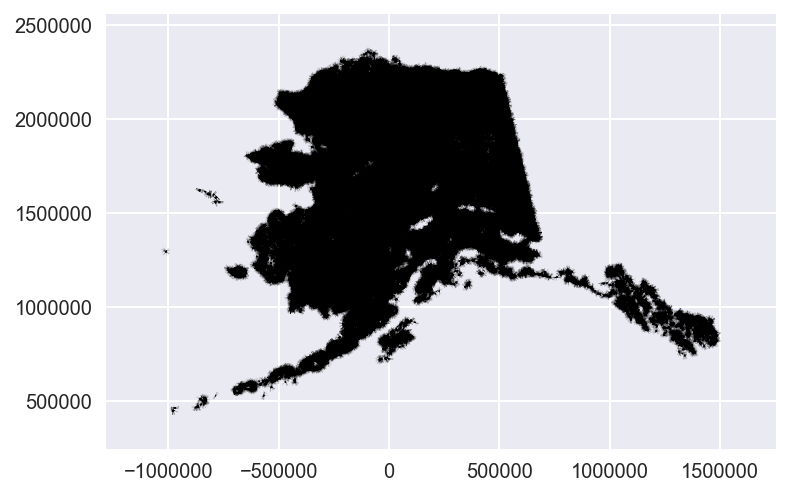

In [14]:
wrapper_ak.plot()

## 2)

In [16]:
ak_subgraphs = list(nx.connected_component_subgraphs(ak_undirected))

In [17]:
len(ak_subgraphs)

2213

In [43]:
subgraph_nodes = {}
subgraph_edges = {}

In [44]:

subgraph_nodes = {}
subgraph_edges = {}

for subgraph in ak_subgraphs:
    n = len(subgraph.nodes())
    e = len(subgraph.edges())
    subgraph_edges[e] = subgraph_edges.get(e, 0) + 1
    subgraph_nodes[n] = subgraph_nodes.get(n, 0) + 1
    
    #if e in subgraph_edges == True:
    #    subgraph_edges[e]= subgraph_edges[e]+1
    #    print e
    #else:
    #    subgraph_edges[e] = 1
    #if n in subgraph_nodes == True:
    #    subgraph_nodes[n] = subgraph_nodes[n]+1
    #    print n
    #else:
    #    subgraph_nodes[n] = 1



In [45]:
print len(subgraph_edges.keys())
print len(subgraph_nodes.keys())

313
313


In [46]:
ordered_edges = collections.OrderedDict(sorted(subgraph_edges.items()))

In [66]:
ordered_nodes = collections.OrderedDict(sorted(subgraph_nodes.items()))

In [62]:
keys = ordered_edges.keys()
plt.figure()
y_pos = np.arange(len(keys))
num_subgraphs = ordered_edges.values()
plt.barh(y_pos, num_subgraphs, align='center', alpha=0.5)
plt.yticks(y_pos, num_subgraphs)
plt.xlabel("number of edges")
plt.ylabel('number of subgraphs')
plt.savefig('number_of_edges_subgraphs.pdf')
plt.close()

In [69]:
##TODO:
# for each subgraph chose a starting point and span from that point, 
#   adding corrected edges to large graph (all of alaska)
#   **must check directionality from original (directed) graph before merging edge to determine 
#                                   resultant directionality (and assure correctness)